In [194]:
#!pip install bayesian-optimization  # for google collab
#!pip install git+https://github.com/slremy/netsapi --user --upgrade

In [195]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
from netsapi.challenge import *
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import mlab
from matplotlib import gridspec
%matplotlib inline
from sys import exit, exc_info, argv
from multiprocessing import Pool, current_process
import random as rand
import json
import requests
import numpy as np
import pandas as pd
import statistics
from IPython.display import clear_output
import time

from contextlib import contextmanager
import sys, os
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
from tqdm import tqdm

def newHoleEnv():
    return ChallengeProveEnvironment()
    #return ChallengeSeqDecEnvironment() #Initialise a New Challenge Environment to post entire policy

print("done")

done


# hyper param and init

In [196]:
env = newHoleEnv()

#hyper param
x_start = 0.0
x_end = 1.0
normalisation = 90.0 # reward normalisation
initial_rand_policy = 6 # 5 train + 1 test


# init
policyID_queue = [] # Example [0,1,2]
target_out = [] # example [1]

lista_BOs = []
leave1out_lista_R = []
#lista_R = [] # None so that it bugs if i don t init it

policies = []
detailed_rewards = []
UsedPolicy = 0

# Utility : Neural net

In [197]:

# action val in
x_start = 0.0
x_end = 1.0

old_action = np.array([0.0 , 0.0])
weight = np.array([0.0 , 0.0]) # todo init rand


def nn_sum(w0, w1, x1): # affine
    return w0 + w1*x1
def nn_mul(a,b):
    return a*b
def nn_Modified_sigmoid(x):
    return nn_sigmoid(x)/2 + 0.5
def nn_sigmoid(x):
    return (math.exp( 2.0*x ) - 1.0 ) / (math.exp( 2.0*x ) + 1.0)
def nn_porte(x, mn, mx):
    return max(mn , min(x,mx) )

def nn(action):# reccurent NN ( not used here)
    global old_action
    a1 = nn_sum(weight[0], weight[1], old_action)
    a2 = nn_sum(weight[0], weight[1], action)
    a3 = nn_mul(a1,a2)
    a3 = nn_Modified_sigmoid(a3)
    a4 = nn_porte(a3, x_start, x_end)
    
    
    
    
def nn_balance(w0, a1, a2):
    return w0*a1 + (1.0-w0)*a2
def nn_simple_sum(a,b):
    return a+b


In [198]:
#utility

In [199]:
def truncate_policy_to_needed_param(Allparam, needed_param):
    params = {}
    for key in needed_param:
        params[key]=Allparam[key]
    return params


def queryMyPolicy(policy):
    #print("queryMyPolicy ", policy)
    detailed_reward= {1:0, 2:0, 3:0, 4:0, 5:0}
    env.reset()
    for i in range (1,6):
        nextstate, reward, done, _ = env.evaluateAction([ policy[str(i)+'x'] , policy[str(i)+'y']  ] )
        detailed_reward[i] = reward/ normalisation
    
    global policies, detailed_rewards , UsedPolicy
    
    policies.append(policy)
    detailed_rewards.append(detailed_reward)
    UsedPolicy+=1
    print("Sum of first 2 years: ", detailed_reward[1]+detailed_reward[2])

#  list of hm's target

In [200]:
def target1(**kwargs):
    global policyID_queue, detailed_rewards
    reward = 0.0
    if len( policyID_queue ) > 0 :
        policyID = policyID_queue.pop(0)
        detailed_reward = detailed_rewards[   policyID   ]
        
        for key in target_out:
            #print("detailed_reward: " , detailed_reward[key])
            reward += detailed_reward[key]
    else: # do it online   
        raise SyntaxError('mini BOs should never query online ')
    return reward  #  /90.0  


def target(**kwargs):  
    modeLista = False
    valueLen = 0
    for key, value in kwargs.items(): 
        #print ("target:: ",key," == ",value) 
        if type(value) is np.ndarray:
            modeLista = True
            valueLen = len(value)
        break
    if modeLista:
        result = []
        for _ in range(valueLen):
            reward = target1()
            result.append( reward )
        return result
    else:
        return target1()


# balance's target

In [201]:
def balance_target1(w0, w1):#weights
    w0 = np.asscalar(w0)
    w1 = np.asscalar(w1)
    
    MSE = 0.0
    global leave1out_lista_R
    for lista_R,detailed_reward in zip( leave1out_lista_R , detailed_rewards ) :
        expected_reward = np.asscalar(nn_balance(w0, lista_R[3], nn_simple_sum(lista_R[0], nn_balance(w1, lista_R[1], lista_R[2])  )))
        #print("expected_reward ", expected_reward)
        real_reward = detailed_reward[1] + detailed_reward[2] ####################################################### todo: add rest of the years
        MSE += (expected_reward - real_reward)**2
    return - MSE

def balance_target(w0, w1):
    if type(w0) is np.ndarray:
        result = []
        for a,b in zip(w0, w1):
            reward = balance_target1(a,b)
            result.append( reward )
        return result
    else:
        return balance_target1(w0, w1)

# Train Utility

In [202]:
def fit(bo):
    bo._gp.fit(bo._space.params, bo._space.target)
    
def predict(bo,Policy):
        params =truncate_policy_to_needed_param(Policy, bo.space.keys)

        valLeftPolicy = [] 
        for val in params.values():
            valLeftPolicy.append(val)

        params = np.array( valLeftPolicy)
        params.reshape(1, -1)

        return bo._gp.predict( [params] , return_std=True)

def train_BO_hm(policy_trainSet):
    global policyID_queue,target_out
    
    bos = [] 
    bos_target_out = []
    
    #############################################TODO loop
    bos.append( BayesianOptimization(f=target, pbounds={'1x': (x_start, x_end), '1y': (x_start, x_end)},verbose=0))
    bos_target_out.append( [1] )
    
    bos.append( BayesianOptimization(f=target, pbounds={'2x': (x_start, x_end), '2y': (x_start, x_end)} ,verbose=0))
    bos_target_out.append( [2] )
    
    bos.append( BayesianOptimization(f=target, pbounds={'1x': (x_start, x_end), '1y': (x_start, x_end),'2x': (x_start, x_end), '2y': (x_start, x_end)}   ,verbose=0))
    bos_target_out.append( [2] )
    
    bos.append( BayesianOptimization(f=target, pbounds={'1x': (x_start, x_end), '1y': (x_start, x_end),'2x': (x_start, x_end), '2y': (x_start, x_end)}   ,verbose=0))
    bos_target_out.append( [1,2] )
    
    
    for bo,aBO_target_out in zip(bos, bos_target_out):
        policyID_queue = policy_trainSet[:]
        target_out = aBO_target_out
        #bo.maximize(init_points=5, n_iter=0, acq='ucb', kappa=10)
        for apolicyID in policy_trainSet:
            apolicy = policies[apolicyID]
            params = {}
            for key in bo.space.keys:
                params[key]=apolicy[key]
            bo.probe(params=params,lazy=True)    
            bo.maximize(init_points=0, n_iter=0, acq='ucb')
    return bos


    

## 2d_plot (balance)

In [203]:
# for the training
n = 1e5
x = y = np.linspace(x_start, x_end, 300)# was 300
X, Y = np.meshgrid(x, y)
x = X.ravel()
y = Y.ravel()
X = np.vstack([x, y]).T[:, [1, 0]]
VAL_Max = 5


def posterior(bo, X):
    #ur = unique_rows(bo.X)
    #x_obs = np.array([[res["params"]["w0"], res["params"]["w1"]] for res in bo.res])
    #y_obs = np.array([res["target"] for res in bo.res])
    
    
    fit(bo)
    mu, sigma = bo._gp.predict(X, return_std=True)
    return mu, sigma

def plot_2d(bo,name=None):

    mu, s = posterior(bo, X)

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    gridsize=150

    # fig.suptitle('Bayesian Optimization in Action', fontdict={'size':30})
    x_obs = np.array([[res["params"]["w0"], res["params"]["w1"]] for res in bo.res])
    # GP regression output
    ax[0][0].set_title('Gausian Process Predicted Mean; max='+str(round(np.amax(mu)*90,0))+" min="+str(round(np.amin(mu)*90,0)), fontdict={'size':15})
    im00 = ax[0][0].hexbin(x, y, C=mu, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=np.amin(mu), vmax=np.amax(mu))
    ax[0][0].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0][0].set_xlabel("w1")
    ax[0][0].plot(x_obs[:, 1], x_obs[:, 0], 'D', markersize=4, color='k', label='Observations')

    ax[0][1].set_title('Target Function', fontdict={'size':15})

    ax[1][0].set_title('Gausian Process Variance', fontdict={'size':15})
    im01 = ax[1][0].hexbin(x, y, C=s, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=0, vmax=1)
    ax[1][0].axis([x.min(), x.max(), y.min(), y.max()])

    ax[1][1].set_title('Acquisition Function', fontdict={'size':15})
    # acquisition func skipped

    for im, axis in zip([im00, im01], ax.flatten()):#, im10, im11
        cb = fig.colorbar(im, ax=axis)
        # cb.set_label('Value')

    if name is None:
        name = '_'

    plt.tight_layout()

    # Save or show figure?
    # fig.savefig('bo_eg_' + name + '.png')
    plt.show()
    plt.close(fig)


## model target

In [204]:
def model_target1(y1x, y1y, y2x, y2y):#weights
    #y1x = np.asscalar(y1x)
    #y1y = np.asscalar(y1y)
    #y2x = np.asscalar(y2x)
    #y2y = np.asscalar(y2y)
    
    global Best_BOhm_lista, w0,w1
    lista_R = []
    for bo in Best_BOhm_lista:
        mu, sigma = predict(bo, {'1x':y1x,'1y':y1y,'2x':y2x,'2y':y2y,'3x':0,'3y':0,'4x':0,'4y':0,'5x':0,'5y':0} ) ######################### todo scale up
        lista_R.append(mu)
        
    expected_reward = np.asscalar(nn_balance(w0, lista_R[3], nn_simple_sum(lista_R[0], nn_balance(w1, lista_R[1], lista_R[2])  )))
    #print("model expected_reward ", expected_reward)
    #real_reward = detailed_reward[1] + detailed_reward[2] ####################################################### todo: add rest of the years
    #MSE += (expected_reward - real_reward)**2
        
    return expected_reward




def model_target(**kwargs):
    all_val = []
    for key, value in kwargs.items():
        all_val.append(value)
        
    if type(all_val[0]) is np.ndarray:
        result = []
        for a,b,c,d in zip(all_val[0], all_val[1], all_val[2], all_val[3]):
            reward = model_target(a,b,c,d)
            result.append( reward )
        return result
    else:
        return model_target1(all_val[0], all_val[1], all_val[2], all_val[3])

# Train

In [205]:

def train_model():
    #leave 1 out for the balance weights and MSE
    for LeftPolicyID in range(UsedPolicy): 
        ### set ids ...
        policy_trainSet = list( range(UsedPolicy) )
        policy_trainSet.pop(LeftPolicyID)
        #print("policy_trainSet ", policy_trainSet)

        ## train BO hm
        global lista_BOs
        lista_BOs = train_BO_hm(policy_trainSet)

        ## predict Ri for each hm
        LeftPolicy = policies[LeftPolicyID]
        #global lista_R
        lista_R = []
        for bo in lista_BOs:
            bo._gp.fit(bo._space.params, bo._space.target)
            mu, sigma = predict(bo,LeftPolicy)

            #print("mu, sigma  ", mu," ", sigma)
            lista_R.append(mu)

        leave1out_lista_R.append(lista_R)

    ## train weights with MSE
    balance_bo = BayesianOptimization(
        f=balance_target, 
        pbounds={'w0': (0.0, 1.0), 'w1': (0.0, 1.0)},
        verbose=0, # verbose = 1 _prints only when a maximum is observed, verbose = 0 is silent
        )
    
    
    balance_bo.maximize(init_points=15, n_iter=0, acq='ucb', kappa=10)
    #plot_2d(balance_bo)
    #balance_bo.maximize(init_points=0, n_iter=5, acq='ucb', kappa=10)
    #plot_2d(balance_bo)
    balance_bo.maximize(init_points=0, n_iter=5, acq='ucb', kappa=2.5)
    plot_2d(balance_bo)
    #balance_bo.maximize(init_points=0, n_iter=2, acq='ucb', kappa=1)
    #balance_bo.maximize(init_points=0, n_iter=2, acq='ucb', kappa=0)

    
    # keep the best weights and BO hm regarding the MSE
    bestBalance = balance_bo.max
    print("bestBalance ", bestBalance)
    global w0,w1
    w0 = bestBalance['params']['w0']
    w1 = bestBalance['params']['w1']
    
    
    # add the left policy to the hm ( train lista of bo hm using all my episodes/ policies )
    global Best_BOhm_lista
    Best_BOhm_lista =  train_BO_hm(list( range(UsedPolicy) ))
    for bo in Best_BOhm_lista:
        fit(bo)
        
    # 1 BO 10 dim   ## todo i should train using only optimiser.prone on my points
    model_bo = BayesianOptimization(
        f=model_target,
        pbounds={'1x': (x_start, x_end), '1y': (x_start, x_end),'2x': (x_start, x_end), '2y': (x_start, x_end)},
        verbose=0,
        )
    
    for OnlineTestedPolicy in policies:
        p = truncate_policy_to_needed_param(OnlineTestedPolicy, ['1x','1y','2x','2y'])
        model_bo.register(params=p, target=model_target1(p['1x'],p['1y'],p['2x'],p['2y'],)  )
    model_bo.maximize(init_points=0, n_iter=0)
    model_bo.maximize(init_points=15, n_iter=20, acq='ucb', kappa=10)
    model_bo.maximize(init_points=0, n_iter=5, acq='ucb', kappa=5)
    model_bo.maximize(init_points=0, n_iter=3, acq='ucb', kappa=1)
    model_bo.maximize(init_points=0, n_iter=2, acq='ucb', kappa=0)
    
    # 1 suggestion
    print("UsedPolicy ",UsedPolicy)
    used_kappa = 9.5
    if (UsedPolicy>12):#explore less
        used_kappa = 4
    if (UsedPolicy>16):#explore less
        used_kappa = 2.5
    if (UsedPolicy>18):#explore less
        used_kappa = 1.5
    if (UsedPolicy>19):#explore less
        used_kappa = 0.7
        
    util = UtilityFunction( kind='ucb', kappa=9.5, xi=0.0)
    #next_policy = Best_BOhm_lista[-1].suggest(util)
    next_policy = model_bo.suggest(util)
    print("next_policy exploration", next_policy )
    fit(model_bo)
    print("our prediction: ", predict(model_bo,next_policy ) )
    return next_policy
    #next_policy = model_bo.max
    #print("next_policy exploitation", next_policy['params'])
    #print("our prediction: ", next_policy['target'] )
    #return next_policy['params']

# main

In [206]:
#code
for _ in range(initial_rand_policy):
        queryMyPolicy({'1x':rand.random(),'1y':rand.random(),'2x':rand.random(),'2y':rand.random(),'3x':rand.random(),'3y':rand.random(),'4x':rand.random(),'4y':rand.random(),'5x':rand.random(),'5y':rand.random()})         

105  Evaluations Remaining
104  Evaluations Remaining
103  Evaluations Remaining
102  Evaluations Remaining
101  Evaluations Remaining
Sum of first 2 years:  -0.09548394320869429
100  Evaluations Remaining
99  Evaluations Remaining
98  Evaluations Remaining
97  Evaluations Remaining
96  Evaluations Remaining
Sum of first 2 years:  -0.1092260309597205
95  Evaluations Remaining
94  Evaluations Remaining
93  Evaluations Remaining
92  Evaluations Remaining
91  Evaluations Remaining
Sum of first 2 years:  -0.1496699971303846
90  Evaluations Remaining
89  Evaluations Remaining
88  Evaluations Remaining
87  Evaluations Remaining
86  Evaluations Remaining
Sum of first 2 years:  0.31554655550334315
85  Evaluations Remaining
84  Evaluations Remaining
83  Evaluations Remaining
82  Evaluations Remaining
81  Evaluations Remaining
Sum of first 2 years:  0.17630672889948884
80  Evaluations Remaining
79  Evaluations Remaining
78  Evaluations Remaining
77  Evaluations Remaining
76  Evaluations Remainin







  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

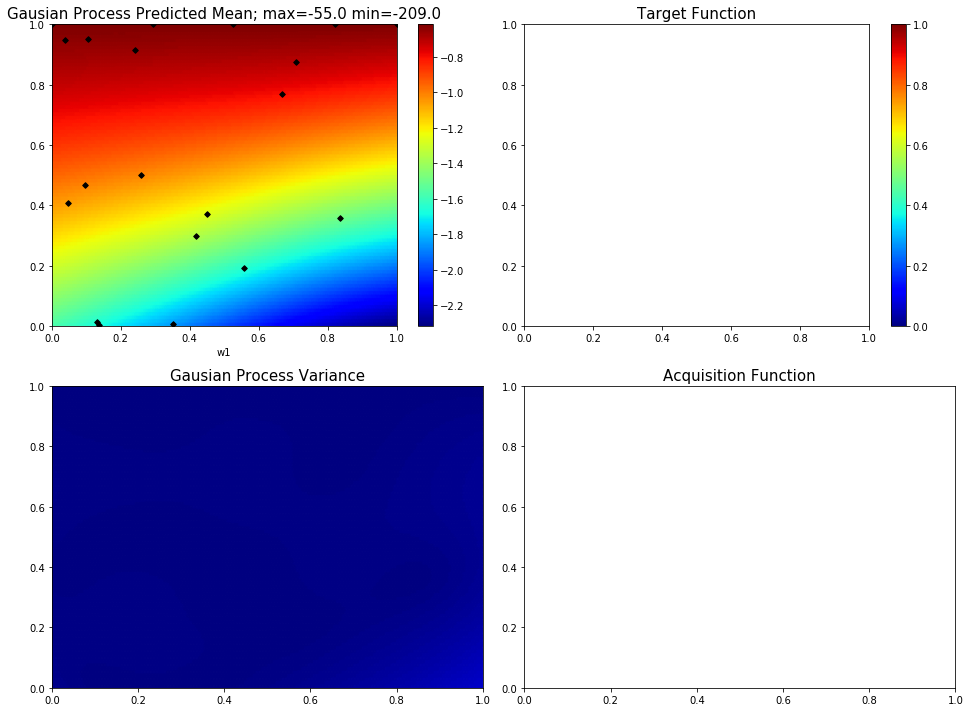

bestBalance  {'target': -0.6163487001269472, 'params': {'w0': 1.0, 'w1': 1.0}}
UsedPolicy  6
next_policy exploration {'1x': 0.6928715392161703, '1y': 0.9999995907588506, '2x': 3.034554886434787e-08, '2y': 6.846562207485849e-08}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00018582]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


our prediction:  (array([0.85692468]), array([0.00979974]))
75  Evaluations Remaining
74  Evaluations Remaining
73  Evaluations Remaining
72  Evaluations Remaining
71  Evaluations Remaining
Sum of first 2 years:  0.032796986493298014








  7%|█████▊                                                                            | 1/14 [02:58<38:38, 178.38s/it]

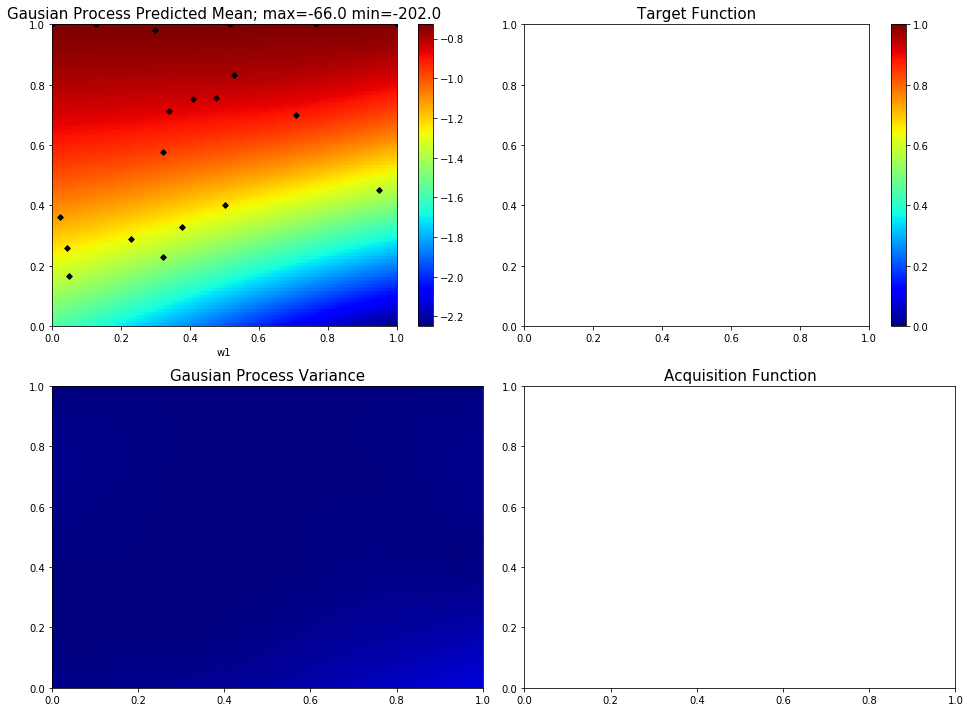

bestBalance  {'target': -0.7292064058674448, 'params': {'w0': 1.0, 'w1': 1.0}}
UsedPolicy  7
next_policy exploration {'1x': 0.8123624891141435, '1y': 0.49296722093862455, '2x': 0.0, '2y': 0.9999999999612919}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.86360759e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


our prediction:  (array([0.28543727]), array([0.04760164]))
70  Evaluations Remaining
69  Evaluations Remaining
68  Evaluations Remaining
67  Evaluations Remaining
66  Evaluations Remaining
Sum of first 2 years:  0.0637727243820401








 14%|███████████▋                                                                      | 2/14 [05:04<32:33, 162.81s/it]

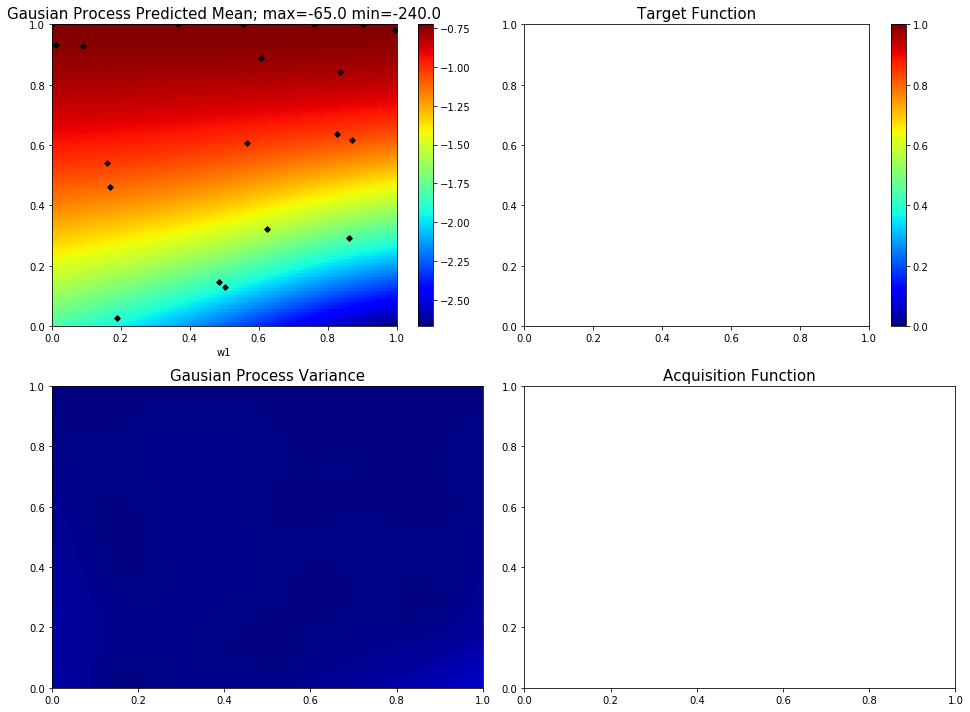

bestBalance  {'target': -0.7293107539585301, 'params': {'w0': 1.0, 'w1': 0.759104627170737}}
UsedPolicy  8
next_policy exploration {'1x': 0.9987059250311965, '1y': 0.6071662870901705, '2x': 0.02179700714537125, '2y': 0.5733691789179547}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.87935438e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.87444085e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


our prediction:  (array([0.26724838]), array([0.04070112]))
65  Evaluations Remaining
64  Evaluations Remaining
63  Evaluations Remaining
62  Evaluations Remaining
61  Evaluations Remaining
Sum of first 2 years:  0.10698509418418863








 21%|█████████████████▌                                                                | 3/14 [07:14<28:02, 152.94s/it]

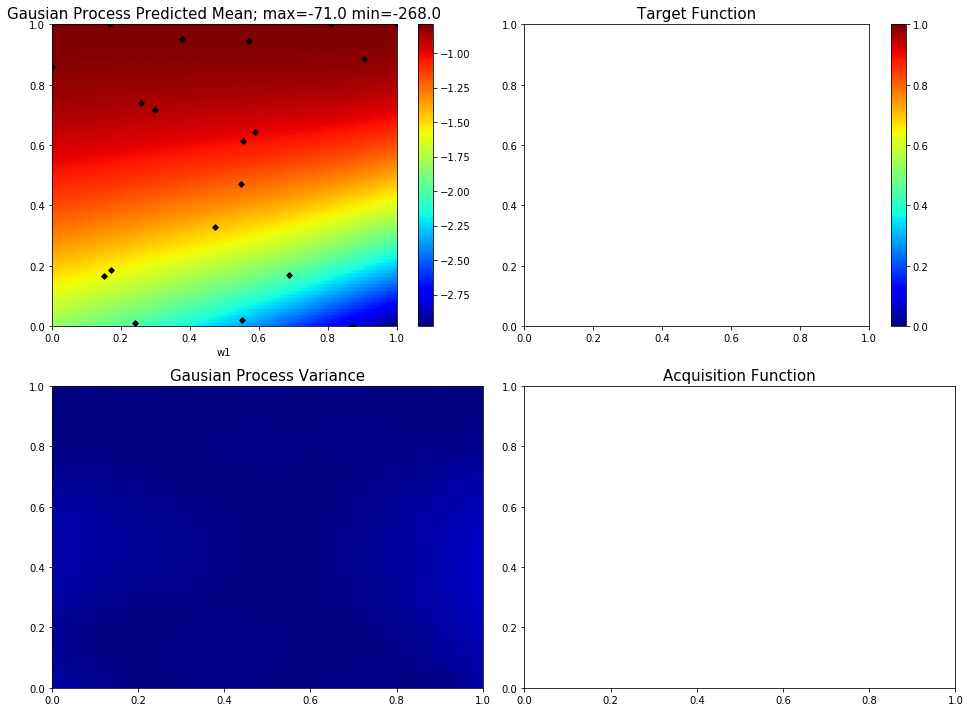

bestBalance  {'target': -0.795011996527592, 'params': {'w0': 1.0, 'w1': 5.551115123125783e-17}}
UsedPolicy  9
next_policy exploration {'1x': 0.9999999999996575, '1y': 0.9999999999988535, '2x': 0.33811912631854135, '2y': 1.0}
our prediction:  (array([0.08276024]), array([0.057889]))
60  Evaluations Remaining
59  Evaluations Remaining
58  Evaluations Remaining
57  Evaluations Remaining
56  Evaluations Remaining
Sum of first 2 years:  -0.206375828065553








 29%|███████████████████████▍                                                          | 4/14 [09:31<24:42, 148.20s/it]

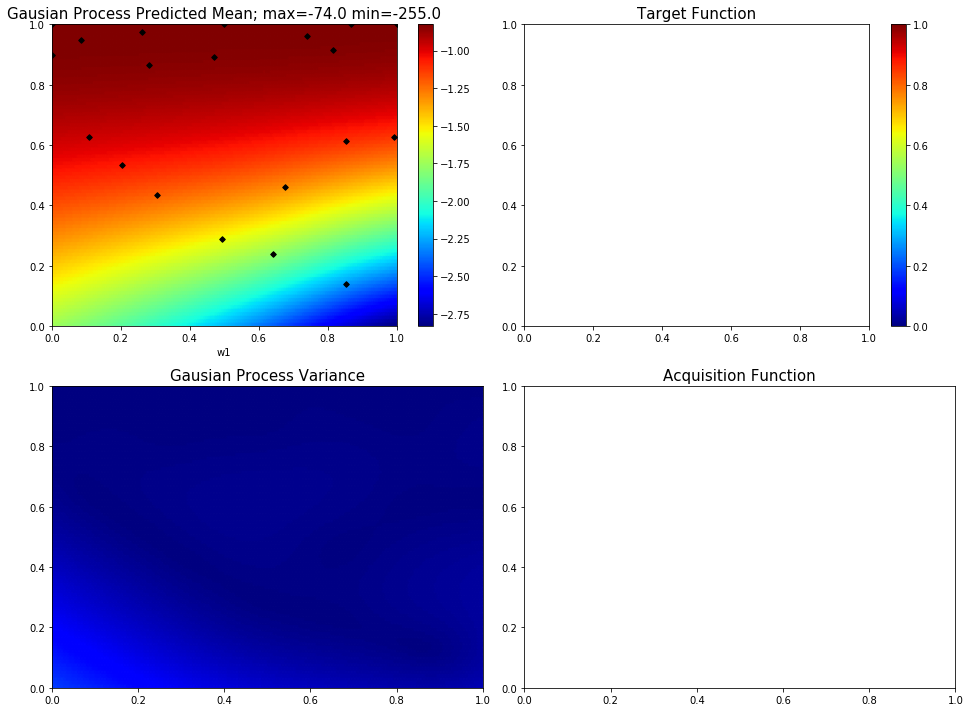

bestBalance  {'target': -0.8267126029373916, 'params': {'w0': 0.973251921626865, 'w1': 0.2610314951423277}}
UsedPolicy  10
next_policy exploration {'1x': 0.670836563792523, '1y': 0.36420735789629344, '2x': 0.18545684489600622, '2y': 0.30604402014011123}
our prediction:  (array([0.41398641]), array([0.01522152]))
55  Evaluations Remaining
54  Evaluations Remaining
53  Evaluations Remaining
52  Evaluations Remaining
51  Evaluations Remaining
Sum of first 2 years:  0.2803630663362863








 36%|█████████████████████████████▎                                                    | 5/14 [11:57<22:05, 147.27s/it]

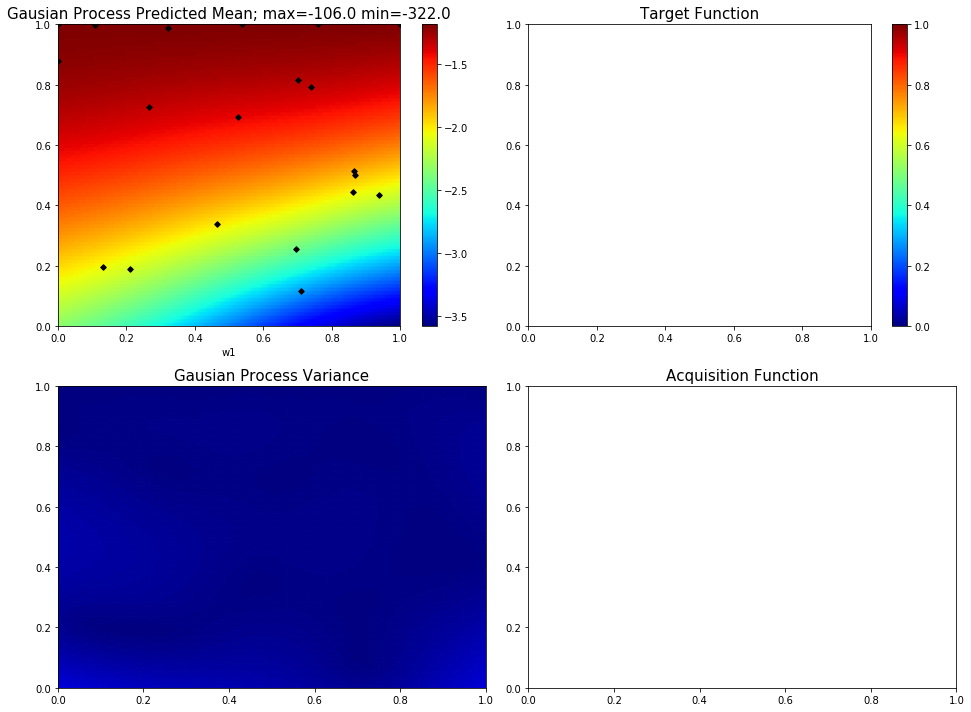

bestBalance  {'target': -1.1834622355958833, 'params': {'w0': 1.0, 'w1': 1.0}}
UsedPolicy  11
next_policy exploration {'1x': 0.4831618837262186, '1y': 0.6435895682762279, '2x': 0.006497102628172935, '2y': 0.22809496590383094}
our prediction:  (array([0.3687496]), array([0.02301911]))
50  Evaluations Remaining
49  Evaluations Remaining
48  Evaluations Remaining
47  Evaluations Remaining
46  Evaluations Remaining
Sum of first 2 years:  -0.06810848387726536








 43%|███████████████████████████████████▏                                              | 6/14 [14:33<19:59, 149.96s/it]

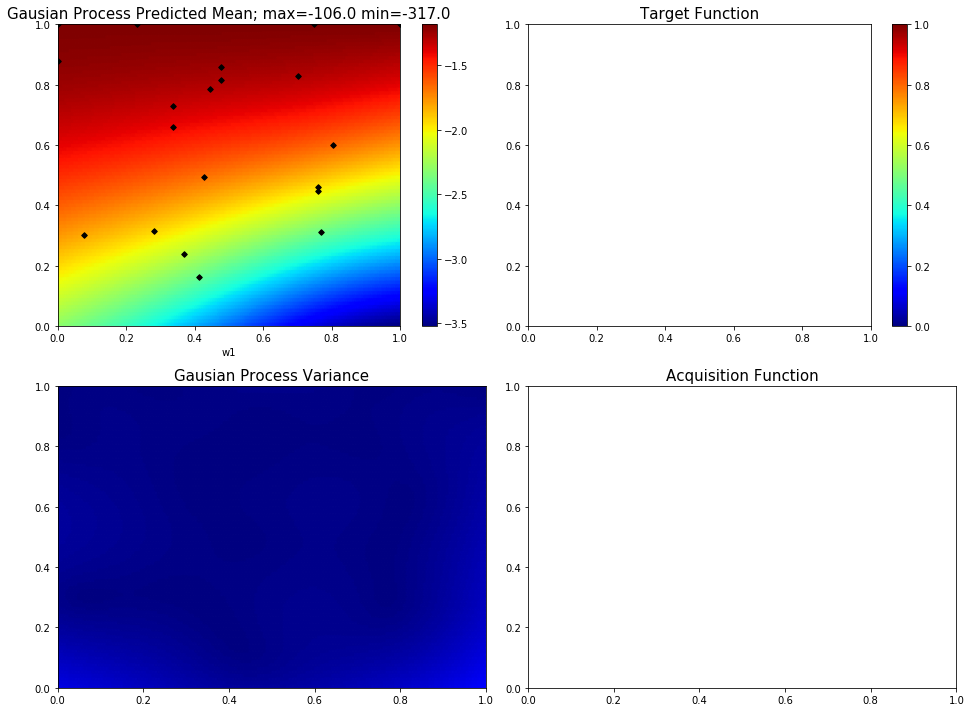

bestBalance  {'target': -1.1834941716953153, 'params': {'w0': 1.0, 'w1': 0.0}}
UsedPolicy  12
next_policy exploration {'1x': 1.0, '1y': 1.0, '2x': 0.0, '2y': 0.31381229188372356}
our prediction:  (array([0.01560011]), array([0.08055236]))
45  Evaluations Remaining
44  Evaluations Remaining
43  Evaluations Remaining
42  Evaluations Remaining
41  Evaluations Remaining
Sum of first 2 years:  0.08211407643372357








 50%|█████████████████████████████████████████                                         | 7/14 [16:26<16:12, 138.93s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0011262]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00110362]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00107399]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


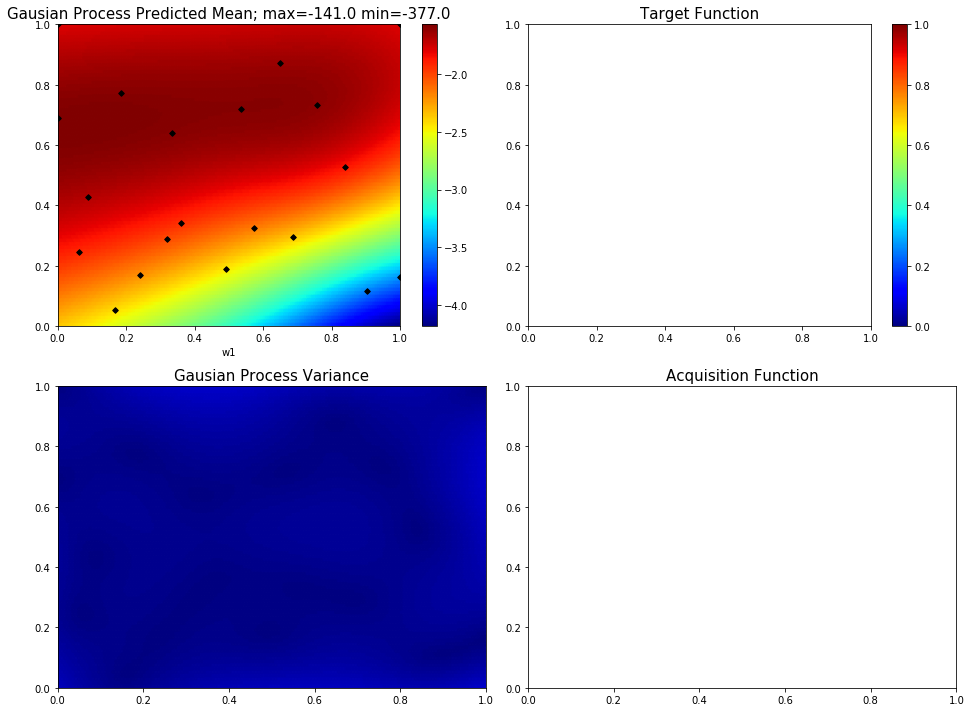

bestBalance  {'target': -1.5747149995849306, 'params': {'w0': 0.6914263081611849, 'w1': 0.0}}
UsedPolicy  13
next_policy exploration {'1x': 0.689905011481733, '1y': 0.0, '2x': 0.0, '2y': 0.5744916169057541}
our prediction:  (array([0.00057449]), array([0.16974175]))
40  Evaluations Remaining
39  Evaluations Remaining
38  Evaluations Remaining
37  Evaluations Remaining
36  Evaluations Remaining
Sum of first 2 years:  -0.05101693260299288








 57%|██████████████████████████████████████████████▊                                   | 8/14 [17:55<12:24, 124.08s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00020757]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00092636]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0014561]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
C:\Progr

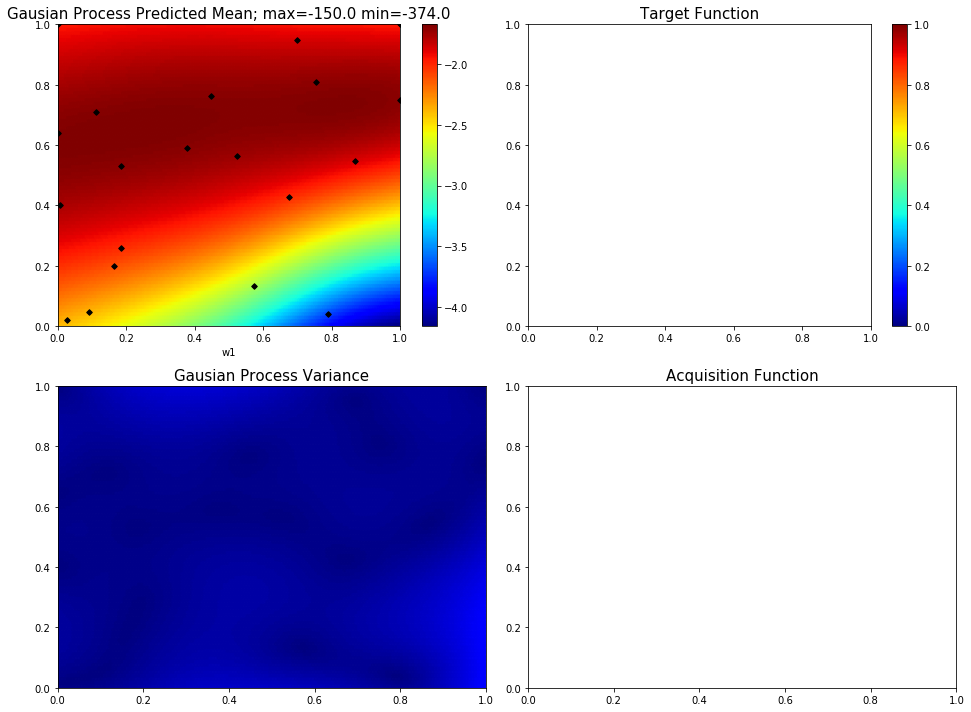

bestBalance  {'target': -1.6807103638742809, 'params': {'w0': 0.6410594507446434, 'w1': 0.0}}
UsedPolicy  14
next_policy exploration {'1x': 0.0, '1y': 1.0, '2x': 0.4999426140920548, '2y': 0.0}
our prediction:  (array([-0.00170111]), array([0.1016378]))
35  Evaluations Remaining
34  Evaluations Remaining
33  Evaluations Remaining
32  Evaluations Remaining
31  Evaluations Remaining
Sum of first 2 years:  0.03351553049035849








 64%|████████████████████████████████████████████████████▋                             | 9/14 [19:36<09:45, 117.03s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04153897e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


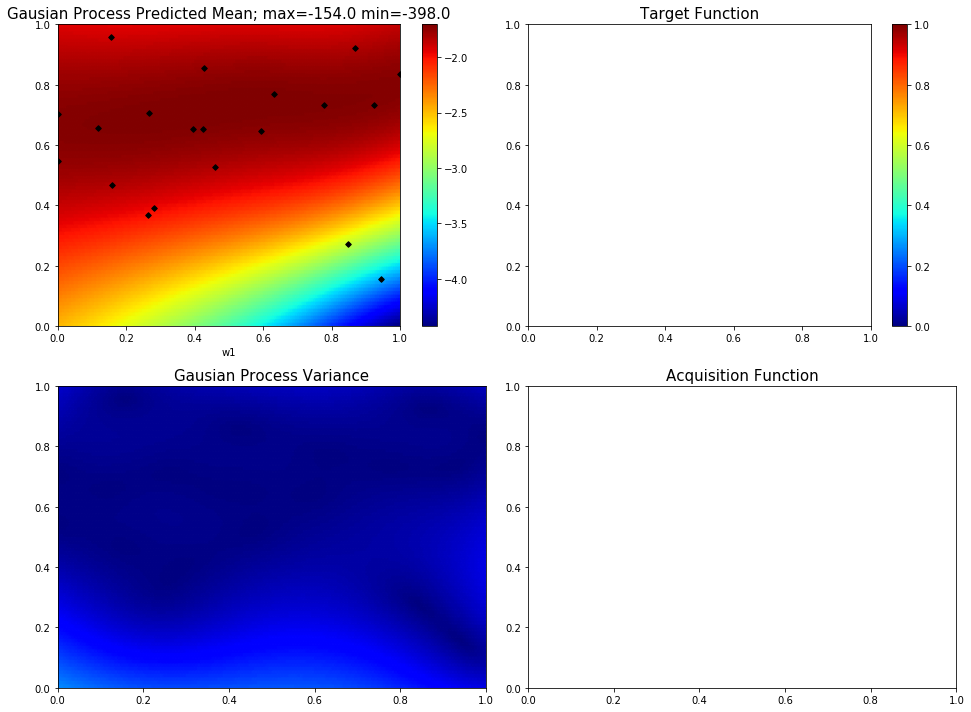

bestBalance  {'target': -1.7088197054197634, 'params': {'w0': 0.7073727157487171, 'w1': 0.26768973011244046}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00023133]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


UsedPolicy  15
next_policy exploration {'1x': 0.0, '1y': 1.0, '2x': 0.0, '2y': 0.0}
our prediction:  (array([-0.1293367]), array([0.15154821]))
30  Evaluations Remaining
29  Evaluations Remaining
28  Evaluations Remaining
27  Evaluations Remaining
26  Evaluations Remaining
Sum of first 2 years:  -0.09601661116508564








 71%|█████████████████████████████████████████████████████████▊                       | 10/14 [21:11<07:22, 110.50s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00054511]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00038988]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.2800171e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


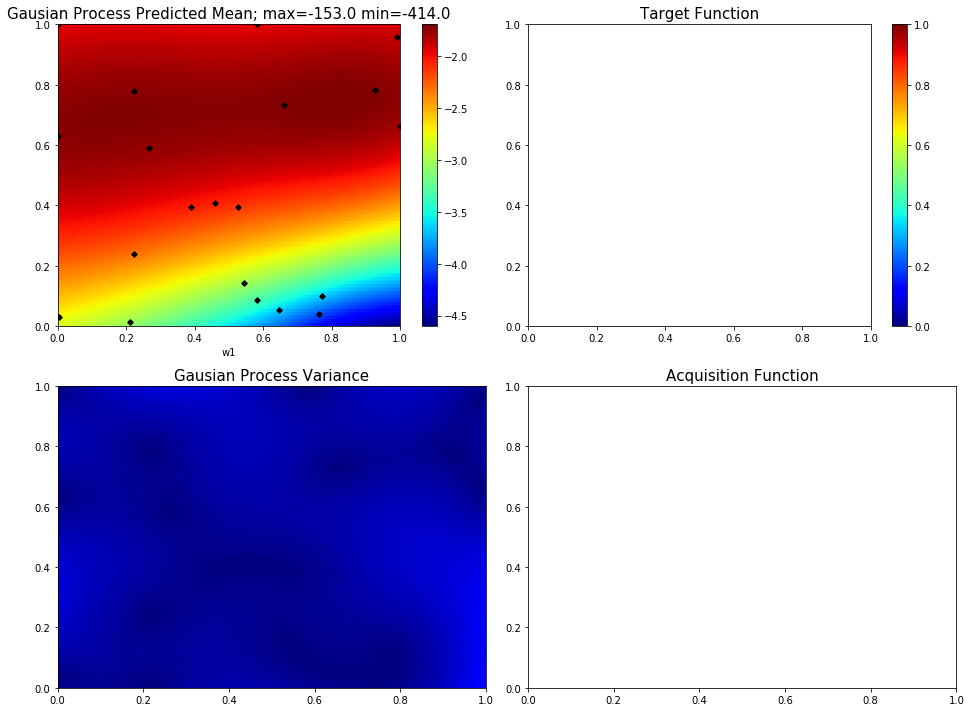

bestBalance  {'target': -1.7116856827435187, 'params': {'w0': 0.7337725085786788, 'w1': 0.6600212406355884}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00049805]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


UsedPolicy  16
next_policy exploration {'1x': 0.0, '1y': 0.0, '2x': 1.0, '2y': 1.0}
our prediction:  (array([-0.97639923]), array([0.27765044]))
25  Evaluations Remaining
24  Evaluations Remaining
23  Evaluations Remaining
22  Evaluations Remaining
21  Evaluations Remaining
Sum of first 2 years:  -0.026829082138956406








 79%|███████████████████████████████████████████████████████████████▋                 | 11/14 [22:36<05:07, 102.65s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00065486]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


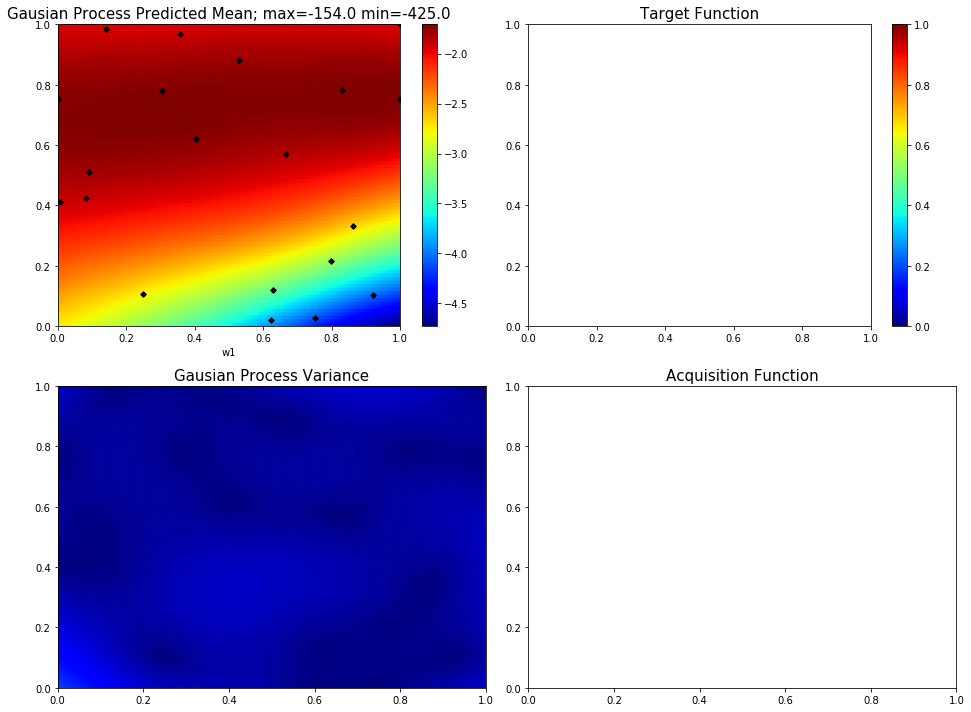

bestBalance  {'target': -1.7142962044326544, 'params': {'w0': 0.7815935430212193, 'w1': 0.8290688289238869}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00029174]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


UsedPolicy  17
next_policy exploration {'1x': 0.0, '1y': 0.43876191314914137, '2x': 0.0, '2y': 0.0}
our prediction:  (array([0.19827687]), array([0.2445074]))
20  Evaluations Remaining
19  Evaluations Remaining
18  Evaluations Remaining
17  Evaluations Remaining
16  Evaluations Remaining
Sum of first 2 years:  -0.012641508747996907








 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [23:58<03:13, 96.50s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00094921]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0007595]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


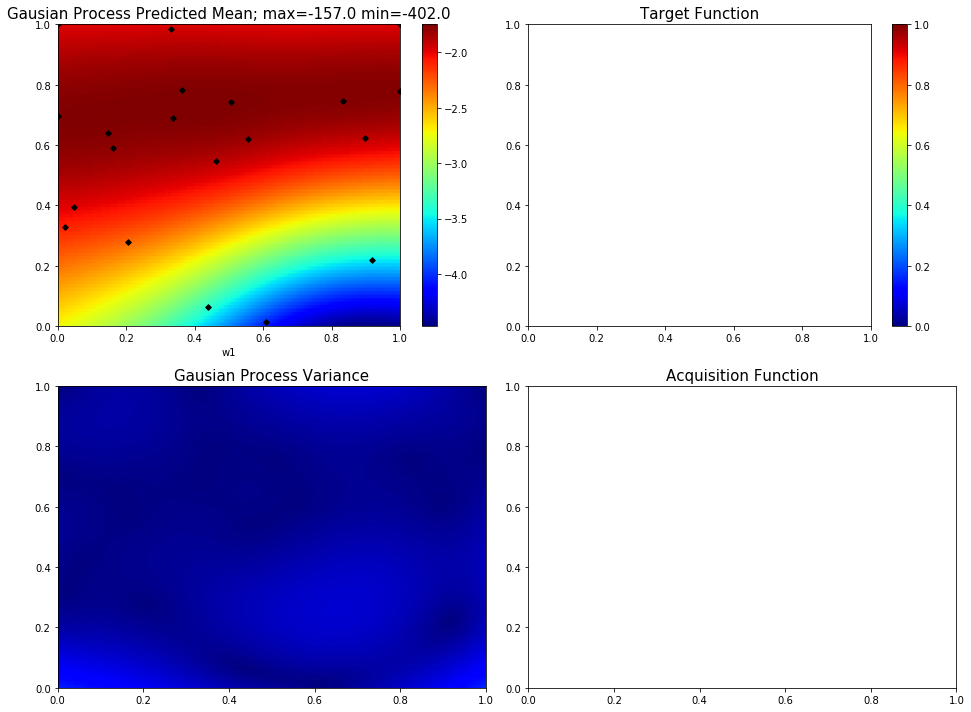

bestBalance  {'target': -1.7509475305079936, 'params': {'w0': 0.7442926753875471, 'w1': 0.5045842334057219}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00049213]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


UsedPolicy  18
next_policy exploration {'1x': 1.0, '1y': 0.0, '2x': 1.0, '2y': 1.0}
our prediction:  (array([0.03836574]), array([0.141483]))
15  Evaluations Remaining
14  Evaluations Remaining
13  Evaluations Remaining
12  Evaluations Remaining
11  Evaluations Remaining
Sum of first 2 years:  -0.38421852380208665








 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [25:25<01:33, 93.86s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00111785]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00041366]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


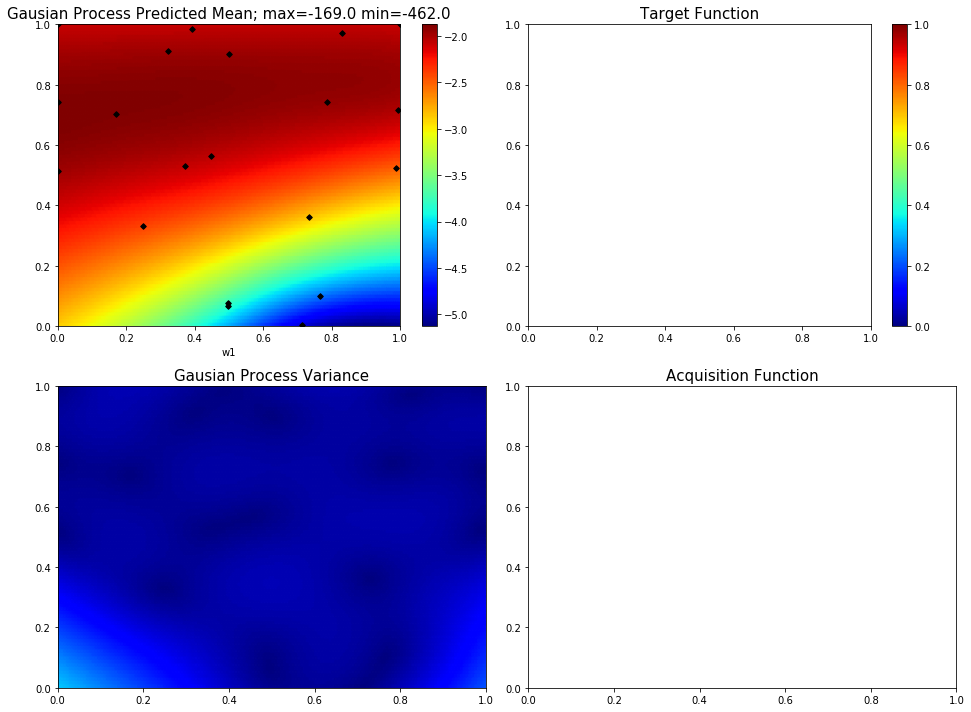

bestBalance  {'target': -1.8790510833540797, 'params': {'w0': 0.7439368444106482, 'w1': 0.0}}
UsedPolicy  19
next_policy exploration {'1x': 0.0, '1y': 1.0, '2x': 0.0, '2y': 0.5020318375673863}
our prediction:  (array([-0.12132762]), array([0.15029034]))
10  Evaluations Remaining
9  Evaluations Remaining
8  Evaluations Remaining
7  Evaluations Remaining
6  Evaluations Remaining
Sum of first 2 years:  0.15038668095749397








100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [27:11<00:00, 97.23s/it]

In [207]:
#print(UsedPolicy)
#print(20-UsedPolicy)
try:
    for i in tqdm(range(UsedPolicy, 20)):  #while UsedPolicy<20:
        next_policy = train_model()
        next_policy['3x'] = rand.random()
        next_policy['3y'] = rand.random()
        next_policy['4x'] = rand.random()
        next_policy['4y'] = rand.random()
        next_policy['5x'] = rand.random()
        next_policy['5y'] = rand.random()
        queryMyPolicy(next_policy)
    
            
except KeyboardInterrupt:
    pass

In [208]:
y2 = [ e[1]+e[2] for e in detailed_rewards ]
y2 = np.array(y2)
print(y2)
np.amax(y2)*normalisation # 66.6  #57.0 # 30.9 # 48.6
# 27 26

[-0.09548394 -0.10922603 -0.14967     0.31554656  0.17630673 -0.59323638
  0.03279699  0.06377272  0.10698509 -0.20637583  0.28036307 -0.06810848
  0.08211408 -0.05101693  0.03351553 -0.09601661 -0.02682908 -0.01264151
 -0.38421852  0.15038668]


28.399189995300883

In [209]:
policies

[{'1x': 0.3372052451296793,
  '1y': 0.22178742193014866,
  '2x': 0.849839600460407,
  '2y': 0.20550542690761942,
  '3x': 0.7740803500462023,
  '3y': 0.9072911671265,
  '4x': 0.307464927359827,
  '4y': 0.5364904018251956,
  '5x': 0.9617726531587353,
  '5y': 0.7138438970534181},
 {'1x': 0.09814892743373704,
  '1y': 0.005828040902449372,
  '2x': 0.15321787771372175,
  '2y': 0.1582602357706827,
  '3x': 0.46323988016936646,
  '3y': 0.0664636268160188,
  '4x': 0.8209194914543293,
  '4y': 0.6959497520859824,
  '5x': 0.7135349583893006,
  '5y': 0.5509330793115038},
 {'1x': 0.09831735869500957,
  '1y': 0.10918292141852648,
  '2x': 0.1935167397808496,
  '2y': 0.3730384597100578,
  '3x': 0.5424334721597461,
  '3y': 0.18853974446751254,
  '4x': 0.3431573210976011,
  '4y': 0.45789897056950146,
  '5x': 0.47904682800029175,
  '5y': 0.205627165486158},
 {'1x': 0.2492434678360984,
  '1y': 0.23351337543545114,
  '2x': 0.38322503030704635,
  '2y': 0.13064163575055432,
  '3x': 0.5498732549100893,
  '3y': 